# Smart Service Project 2023 - Predicting logistic demand for Maastricht
This notebook was created to train and test the model for logistic demand predictions of the Maastricht area. The notebook goes over the following steps:
1. Data collection
2. Data cleaning
3. Model training
4. Model testing
5. Model predictions
6. Importing and cleaning survey data
7. Exporting the results
8. Monte Carlo

The logistic demand is calculated as follows:
1. A model is trained that predicts the number of businesses per Maastricht region per business type.
2. Survey data is used to determine the average number of pallets delivered per business type in Maastricht.
3. These values are used to determine the total logistic demand (in pallets) of Maastricht.
4. This information is then exported to be used by our dashboard that will make further calculations (number of trucks required, amount of electricity etc.)

# 1 Data collection
The data was collected from the Centraal Bureau Statistiek (CBS). This data is on a year-level except the 2009-2012 data which is an aggregation of three years.
Collection was performed manually using the following link:
https://dataportal.cbs.nl/detail/CBS/84799NED

A similar link can be found for each different year. On this webpage a large CSV containing the entire dataset can be found.
The csv's are all added to the data/raw folder of this project with a clear name identifying the year of the data (this is important when combining the data).

### 1.1 Import the libraries

In [39]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os
import re
from pycaret.regression import *

# Settings:
train_models = False

### 1.2 Import the data
Define a function that:
* Imports the data from a csv file
* Cleans the column names, removing strange characters
* Adds the year of the data

In [40]:
def import_data(path):
    # Read the data from the defined csv file
    data = pd.read_csv("data/raw/" + path, sep=';')

    # Get the column names
    txt = list(data.columns.str.replace('[^\w\s]', ''))

    # Remove strange characters
    for i in range(len(txt)):
        txt[i] = txt[i].replace('_', '')
        txt[i] = re.sub(r" ?\d+$", "", txt[i])

    # Set the cleaned columns
    data.columns = txt

    # Add the year of the data (from the file title)
    year = re.findall(r'\d+', path)
    data = data.assign(year=year[0])
    data["unique_ID"] = data['year'].index.astype(str) + '_' + data['year']

    return data

For each of the csv files in the data/raw folder. Run the import_data function.
The created dataframes are added to a list.

In [41]:
# Create a list of dataframes
dataframes = []
data = os.listdir("data/raw")

# Add the dataframe of each file to the list of dataframes
for j in range(len(data)):
    dataframes.append(import_data(data[j]))

### 1.3 Combine the data
Optimally, pd.concat can be used on all the dataframes at the same time.
However, because some of the dataframes have additional columns the concat function does not perform well.

This is why we first concat the dataframes that are the most similar in structure (combining the years with the same columns).

Storing our progress, the dataframes are saved as seperate files.

In [42]:
data20_22 = pd.concat(dataframes[8:14])
data19 = dataframes[7]
data18 = dataframes[6]
data17 = dataframes[5]
data16 = dataframes[4]
data15 = dataframes[3]
data14 = dataframes[2]
data13 = dataframes[1]
data12 = dataframes[0]

In [43]:
data20_22.to_csv("data/cleaned/data20_22.csv", sep=";")
data19.to_csv("data/cleaned/data19.csv", sep=";")
data18.to_csv("data/cleaned/data18.csv", sep=";")
data17.to_csv("data/cleaned/data17.csv", sep=";")
data16.to_csv("data/cleaned/data16.csv", sep=";")
data15.to_csv("data/cleaned/data15.csv", sep=";")
data14.to_csv("data/cleaned/data14.csv", sep=";")
data13.to_csv("data/cleaned/data13.csv", sep=";")
data12.to_csv("data/cleaned/data12.csv", sep=";")

Combining these dataframes was not possible through the use of pd.concat.
However, importing the created csv files in R and using the tidyverse "bind_rows" function showed to work fine.
https://dplyr.tidyverse.org/reference/bind.html

Although this code can not be ran using this Jupyter notebook we included the r script:
CombineData.R

After running the R script we can import the total dataset back into Jupyter notebook

In [44]:
# Import the completed dataset
df = pd.read_csv("data/TotalDataset.csv", sep=";")
df.head()

,X,ID,WijkenEnBuurten,Gemeentenaam,SoortRegio,Codering,IndelingswijzigingWijkenEnBuurten,AantalInwoners,Mannen,Vrouwen,...,PersonenMetLaagInkomen,PersonenMetHoogInkomen,NietActieven,HuishoudensMetLaagInkomen,HuishoudensMetHoogInkomen,HuishoudensMetLageKoopkracht,PersonenMetEenWWBUitkeringTotaal,PersonenMetEenAOUitkeringTotaal,PersonenMetEenWWUitkeringTotaal,PersonenMetEenAOWUitkeringTotaal
0,0,9557,GM0935,Maastricht,Gemeente,GM0935,.,121575,58120,63455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9558,WK093500,Maastricht,Wijk,WK093500,1,18980,8875,10105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,9559,BU09350000,Maastricht,Buurt,BU09350000,1,2095,980,1115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,9560,BU09350001,Maastricht,Buurt,BU09350001,1,1585,750,840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,9561,BU09350002,Maastricht,Buurt,BU09350002,1,2470,1110,1365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2 Data cleaning
Cleaning the dataset requires the following actions:
* Determining data types
* Selecting the columns that are required for training and remove unwanted columns
* Determine if there are missing values and dealing with them accordingly


## 2.1 Determine data types
It is practical to set the specific data types of the different columns. We can now also remove strange characters from columns that include string. From visual inspection there are only a few columns that contain strings: WijkenEnBuurten, Gemeentenaam, SoortRegio and Codering. We clean these columns and change the type to character.

In [45]:
def clean_column(col):
    # Remove special characters from the strings
    df[col] = df[col].str.replace('\W', '', regex=True)

    # Make string lowercase
    df[col] = df[col].str.lower()

    # Set as category
    df[col] = df[col].astype('category')


clean_column("SoortRegio")

## 2.2 Selecting the columns for training
First we create a heatmap that can provide an indication of the NA values in the dataset. Columns that have a lot of missing data can either be removed or dealt with accordingly.

<AxesSubplot: >

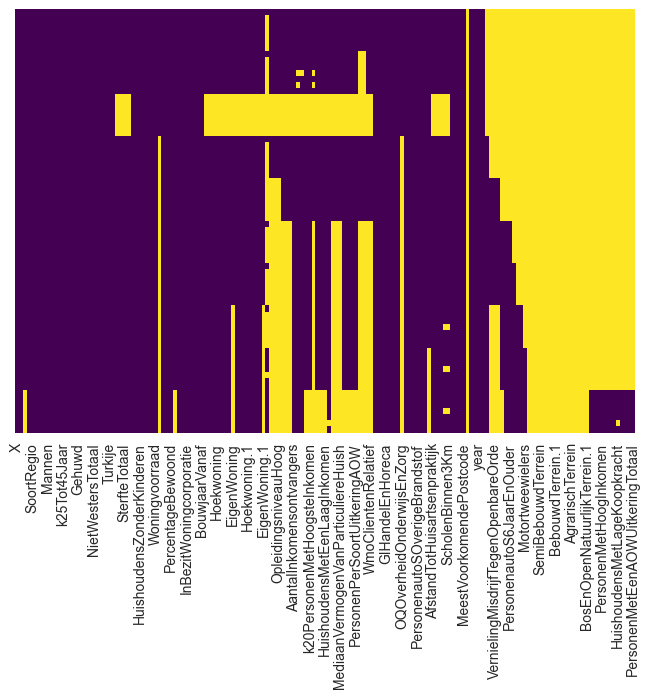

In [46]:
# Select only the Wijk level data
df = df[df['SoortRegio'] == "wijk"]

# Clean the rest of the columns (We do this after the Wijk filtering so we don't retain other categories
for column in ['WijkenEnBuurten', 'Gemeentenaam', 'Codering']:
    clean_column(column)

# Print out the heatmap
sn.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

We can see that there are quite some columns that are not available in the later years but only in the first few years of data (bottom right of the heatmap).

After manually selecting multiple columns that either only have data for the first few years or have no data at all we obtained the following list:

In [47]:
col = ['ID', 'SoortRegio', 'WijkenEnBuurten', 'Gemeentenaam', 'Codering', 'AantalInwoners', 'k0Tot15Jaar',
       'k15Tot25Jaar', 'k25Tot45Jaar', 'k45Tot65Jaar', 'k65JaarOfOuder', 'HuishoudensTotaal', 'Bevolkingsdichtheid',
       'GemiddeldElektriciteitsverbruikTotaal', 'GemiddeldAardgasverbruikTotaal', 'Nettoarbeidsparticipatie',
       'AantalInkomensontvangers', 'GemiddeldInkomenPerInkomensontvanger', 'GemiddeldInkomenPerInwoner',
       'k40PersonenMetLaagsteInkomen', 'k20PersonenMetHoogsteInkomen', 'BedrijfsvestigingenTotaal',
       'ALandbouwBosbouwEnVisserij', 'BFNijverheidEnEnergie', 'GIHandelEnHoreca', 'HJVervoerInformatieEnCommunicatie',
       'KLFinancieleDienstenOnroerendGoed', 'MNZakelijkeDienstverlening', 'OQOverheidOnderwijsEnZorg',
       'RUCultuurRecreatieOverigeDiensten', 'OppervlakteTotaal', 'OppervlakteLand', 'OppervlakteWater',
       'Bedrijfsmotorvoertuigen', 'PercentageOnbewoond', 'year']

df = df[col]

<AxesSubplot: >

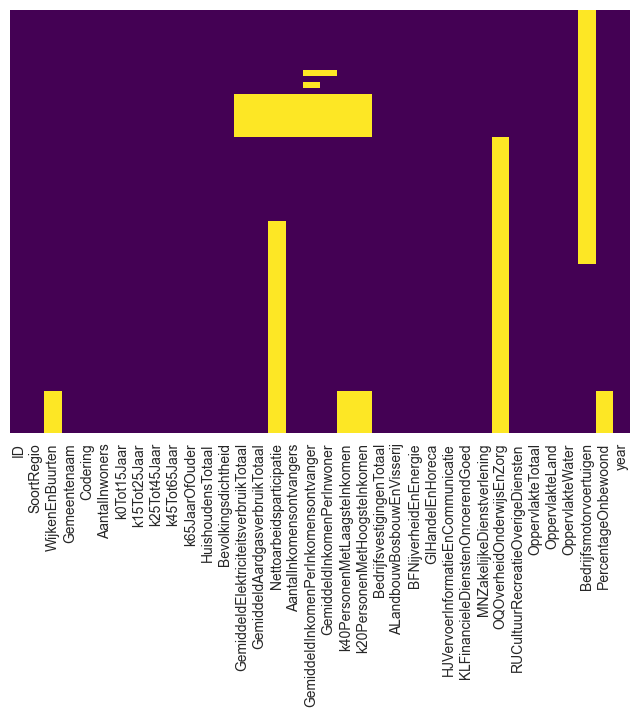

In [48]:
sn.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

Although this dataset still contains many NA values, it represents progress. Once again, we can see that the earlier years within the data (bottom values) miss more data than the later years. Hopefully, these columns do not represent the most important information in our predictions.

## 2.3 Dealing with missing values
Because the actual time series data contains a sum aggregate of each column there are no nan values in our final time series.

In [49]:
df

,ID,SoortRegio,WijkenEnBuurten,Gemeentenaam,Codering,AantalInwoners,k0Tot15Jaar,k15Tot25Jaar,k25Tot45Jaar,k45Tot65Jaar,...,KLFinancieleDienstenOnroerendGoed,MNZakelijkeDienstverlening,OQOverheidOnderwijsEnZorg,RUCultuurRecreatieOverigeDiensten,OppervlakteTotaal,OppervlakteLand,OppervlakteWater,Bedrijfsmotorvoertuigen,PercentageOnbewoond,year
1,9558,wijk,wk093500,maastricht,wk093500,18980,770.0,6030.0,5550.0,2965.0,...,335.0,785.0,420.0,425.0,310,274,37,NaN,15.0,2020
9,9566,wijk,wk093501,maastricht,wk093501,9080,1235.0,1215.0,1655.0,2440.0,...,140.0,390.0,270.0,170.0,915,867,48,NaN,11.0,2020
16,9573,wijk,wk093502,maastricht,wk093502,37610,4145.0,6810.0,8460.0,9515.0,...,95.0,515.0,475.0,370.0,885,885,0,NaN,4.0,2020
27,9584,wijk,wk093503,maastricht,wk093503,2145,210.0,300.0,480.0,645.0,...,20.0,60.0,35.0,50.0,439,388,51,NaN,5.0,2020
33,9590,wijk,wk093504,maastricht,wk093504,30165,3560.0,5940.0,6965.0,7860.0,...,145.0,645.0,550.0,340.0,1321,1309,12,NaN,7.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,11383,wijk,NaN,maastricht,wk093502,37475,12.0,17.0,23.0,27.0,...,75.0,365.0,NaN,315.0,884,884,0,730.0,NaN,2013
495,11394,wijk,NaN,maastricht,wk093503,2215,12.0,14.0,24.0,30.0,...,15.0,50.0,NaN,35.0,438,388,50,170.0,NaN,2013
501,11400,wijk,NaN,maastricht,wk093504,31145,13.0,19.0,24.0,26.0,...,130.0,495.0,NaN,285.0,1321,1308,13,790.0,NaN,2013
509,11408,wijk,NaN,maastricht,wk093505,2750,12.0,10.0,20.0,34.0,...,25.0,65.0,NaN,30.0,1045,965,80,670.0,NaN,2013


In [50]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
ts_data = df[numeric_columns].groupby("year", as_index=False).agg('sum')
ts_data['year'] = pd.to_datetime(ts_data["year"], format='%Y')
ts_data['year'] = ts_data['year'].dt.year
ts_data = ts_data.set_index('year')

ts_data

,ID,AantalInwoners,k0Tot15Jaar,k15Tot25Jaar,k25Tot45Jaar,k45Tot65Jaar,k65JaarOfOuder,HuishoudensTotaal,Bevolkingsdichtheid,GemiddeldElektriciteitsverbruikTotaal,...,HJVervoerInformatieEnCommunicatie,KLFinancieleDienstenOnroerendGoed,MNZakelijkeDienstverlening,OQOverheidOnderwijsEnZorg,RUCultuurRecreatieOverigeDiensten,OppervlakteTotaal,OppervlakteLand,OppervlakteWater,Bedrijfsmotorvoertuigen,PercentageOnbewoond
year,,,,,,,,,,,,,,,,,,,,,
2013,79742,121815,81.0,118.0,160.0,198.0,145.0,66800,17235,21400.0,...,555.0,750.0,2350.0,0.0,1315.0,6002,5662,341,3885.0,0.0
2014,79693,122485,79.0,120.0,159.0,195.0,146.0,67270,17379,20450.0,...,595.0,745.0,2425.0,0.0,1340.0,6002,5662,341,3800.0,63.0
2015,79056,122075,13530.0,23485.0,28535.0,32395.0,24120.0,67625,17339,20070.0,...,610.0,775.0,2460.0,0.0,1390.0,6002,5662,341,3670.0,55.0
2016,66918,122520,13405.0,23425.0,28760.0,32385.0,24525.0,68060,17406,19680.0,...,605.0,780.0,2525.0,0.0,1465.0,6013,5635,379,4435.0,55.0
2017,67751,122730,13230.0,23470.0,28900.0,32045.0,25035.0,68735,17444,19440.0,...,650.0,810.0,2630.0,0.0,1495.0,6013,5635,379,0.0,56.0
2018,66778,122710,12950.0,23740.0,29015.0,31550.0,25425.0,69165,17599,19080.0,...,695.0,830.0,2750.0,0.0,1550.0,6012,5600,413,0.0,55.0
2019,66694,121545,12780.0,23195.0,28675.0,30970.0,25900.0,68485,17448,18740.0,...,730.0,850.0,2850.0,0.0,1595.0,6012,5600,413,0.0,54.0
2020,67072,121575,12615.0,23395.0,28850.0,30445.0,26255.0,68910,17542,18550.0,...,760.0,875.0,2945.0,2220.0,1620.0,6012,5600,413,0.0,52.0
2021,68339,120225,12485.0,22690.0,28590.0,29850.0,26585.0,68030,17563,18760.0,...,775.0,880.0,2980.0,2290.0,1665.0,6012,5600,413,0.0,50.0


# 3 Model training
The model is trained using the pycaret package. This package includes the "compare_models" function that automatically creates test and train sets, tries different model types and shows a comparison of the different models and their performance.

We run this function for each of business type and store the best model to a dictionary containing the business_type and the model itself. Later we can use these models to make our predictions.

The model training can be turned on or off by changing the value of train_models at the top of the notebook file.

In [51]:
if train_models:
    # Define the different business types. Omitted "OQOverheidOnderwijsEnZorg" - Not enough data
    business_types = ["BFNijverheidEnEnergie", "GIHandelEnHoreca", "HJVervoerInformatieEnCommunicatie","KLFinancieleDienstenOnroerendGoed", "MNZakelijkeDienstverlening", "RUCultuurRecreatieOverigeDiensten"]

    # Create a dictionary to contain all the trained models
    model_dict = {}

    # For every business type, train a model
    for business in business_types:
        print("Now training: " + business)

        # Drop all rows without values
        business_ts = ts_data.dropna(subset=[business])
        business_data = data.dropna(subset=[business])

        # Set up the model training - removing multicollinearity (threshold=0.9)
        #setup(
        #    data = business_data, remove_multicollinearity=True,
        #    ignore_features=["BedrijfsvestigingenTotaal", "Codering", "ID", "year", business_types]
        #)

        # Set up the model training - removing multicollinearity (threshold=0.9)
        setup(business_ts,
                    session_id=1,
                    target=business,
                    fold_strategy='timeseries',
                    ignore_features=["BedrijfsvestigingenTotaal", "Codering", "ID", business_types],
                    fold=5,
                    remove_multicollinearity=True,
                    )

        # Train the models and store the best model
        best_model = compare_models()
        final_model = finalize_model(best_model)
        model_dict[business] = {"Model": final_model, "Business_type": business}

        print(model_dict)

## 3.1 Saving the models
To ensure a faster runtime, the model dictionary is pickled for repeated use.

In [52]:
if train_models:
    # Save model dictionary
    with open('output/model_dict.pkl', 'wb') as fp:
        pickle.dump(model_dict, fp)
        print('Dictionary saved successfully to file')

## 3.2 Loading the saved models

In [53]:
# Read model_dictionary
with open('output/model_dict.pkl', 'rb') as fp:
    model_dict = pickle.load(fp)
    print('Model_dictionary:')
    print(model_dict)

Model_dictionary:


AttributeError: 'SimpleImputer' object has no attribute 'keep_empty_features'

# 4 Model testing
Now we created a dictionary of business/region combination that we can use to predict the number of businesses of the upcoming year.
The function "compare_models" already selects a model based on different statistics. As an extra check, we compare the different statistics printed for each model manually as well.

# 5 Predictions
The different models make predictions on the business type level. This means that there is one model for each business type.
For each of these combination we create a new columns with the predictions. These predictions are then aggregated to the business type level.

In [ ]:
# Create a new dictionary that will contain the predicted value dataframes
results_dict = {}

# For each region_type combination in our model dictionary create a model and make a prediction
for region_type in model_dict:
    model = create_model(model_dict[region_type]["Model"])

    # Store the predicte array in the results dictionary
    results_dict[region_type] = {
        "predict_" + region_type: predict_model(model, data=data.groupby(["year"], as_index=False).agg('sum'), verbose=True)["prediction_label"]}

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:32:44
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:32:46
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:32:48
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:32:49
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:32:51
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:32:53
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

After predicting the values, the predicted columns are combined into one dataframe.

In [ ]:
# Combine the different predictions into a single dataframe
df_list = []

for result in results_dict:
    data = pd.DataFrame(results_dict[result].values()).transpose()
    data.columns = [result]
    df_list.append(data)

predicted_df = pd.concat(df_list, ignore_index=True, axis=1)
predicted_df.columns = results_dict.keys()
predicted_df

,BFNijverheidEnEnergie,GIHandelEnHoreca,HJVervoerInformatieEnCommunicatie,KLFinancieleDienstenOnroerendGoed,MNZakelijkeDienstverlening,RUCultuurRecreatieOverigeDiensten
0,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000
1,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
2,1419.693140,1419.693140,1419.693140,1419.693140,1419.693140,1419.693140
3,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000
4,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000
5,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
6,1614.286100,1614.286100,1614.286100,1614.286100,1614.286100,1614.286100
7,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
8,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000
9,3431.420667,3431.420667,3431.420667,3431.420667,3431.420667,3431.420667


# 6 Cleaning and importing survey data
Import the survey data from the data folder.

Combine the dataframe with our predictions and calculate the predicted demand.

In [ ]:
# Import the survey data
survey_df = pd.read_csv("data/SurveyData.csv", sep=";")

# Calculate the total number of pallets per year
survey_df["TotalPerYear"] = survey_df["Average_Total_number_of_palletes_per_month"] * 12

# Add the predicted number of businesses per sector
values = []
for sector in survey_df["Business_sector"]:
    if sector in predicted_df.columns:
        values.append(predicted_df[sector].head(7).values[6])
    else:
        values.append(0)

# Combine the values
survey_df["PredictedBusinesses"] = values
survey_df["PredictedDemand"] = survey_df["PredictedBusinesses"] * survey_df["TotalPerYear"]

survey_df

NameError: name 'predicted_df' is not defined

# 7 Export the predicted demand
Now we export the predicted demand as a csv file to be used in our dashboard. It is also possible to host the file on a cloud service, add it as an API or other delivery options.

In [ ]:
survey_df.to_csv("output/DashboardData.csv", sep=";")

# 8 Monte Carlo Simulation
The monte carlo simulation creates a normal distribution based on the mean amount of palletes and the standard deviation of the palletes. This simulation is ran 10000000 times to create a normal distribution. Based on the law of large numbers, the standard distribution should be around the actual mean of the palletes.

The normal distribution with the estimated mean and standard deviation are plotted, and lastly the estimations for a good, bad and average scenario are displayed with the accompanying probabilities are printed. Based on the outcome of the monte carlo, the scenarios can be displayed in a dashboard and can be used for decision making.

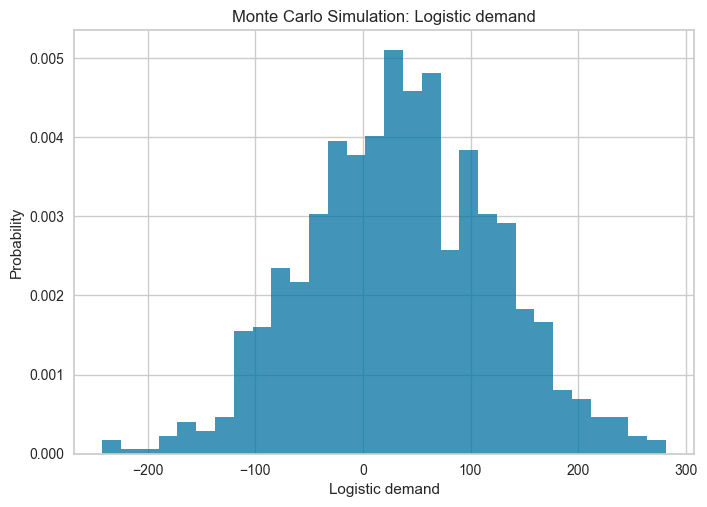

Mean logistic demand: 35.61239422958128
Standard deviation of logistic demand: 87.19339150066398


In [60]:
mean = survey_df['Average_Total_number_of_palletes_per_month'].values.mean()
std_dev = survey_df['SD_Total_number_of_palletes_per_month'].values.mean()
num_samples = 1000

samples = np.random.normal(mean, std_dev, num_samples)

mean_samples = np.mean(samples)
std_dev_samples = np.std(samples)

plt.hist(samples, bins=30, density=True, alpha=0.75)
plt.xlabel('Logistic demand')
plt.ylabel('Probability')
plt.title('Monte Carlo Simulation: Logistic demand')
plt.show()

print(f"Mean logistic demand: {mean_samples}")
print(f"Standard deviation of logistic demand: {std_dev_samples}")

In [61]:
samples

array([ 2.65570989e+01,  6.10410141e+01,  9.25569147e+01,  9.18188403e+01,
        1.03183980e+02, -3.43593751e+01,  1.01647354e+02, -1.09830565e+02,
        5.91137970e+01, -8.31642152e+01,  6.20398990e-02, -3.78696668e+01,
        2.35798408e+02,  6.14053532e+01,  1.71353236e+01,  1.21511980e+02,
        1.40214837e+02,  1.04864663e+02,  1.63104065e+02,  5.05227552e+01,
       -4.28747798e+01, -9.87763570e+01,  1.36981425e+02,  1.72183181e+02,
       -8.42765453e+00,  5.89251590e+01, -9.06201438e+01, -3.34259600e+01,
        1.33852282e+02,  2.40944360e+02, -5.59430580e+01, -1.30477208e+01,
        1.27858753e+02,  1.25207053e+02,  4.69081621e+01,  8.30808502e+01,
       -1.75395501e+01,  1.56941989e+02,  2.59718877e+01, -2.51560820e+01,
        8.04128249e+01,  9.95666535e+01,  4.89397868e+01,  6.93857188e+01,
       -2.02476089e+02, -6.62817729e+01, -2.00393513e+01, -1.07024838e+02,
        1.86290252e+02, -6.02665114e+01,  5.92311560e+01, -7.76589633e+01,
        7.12946947e+01, -

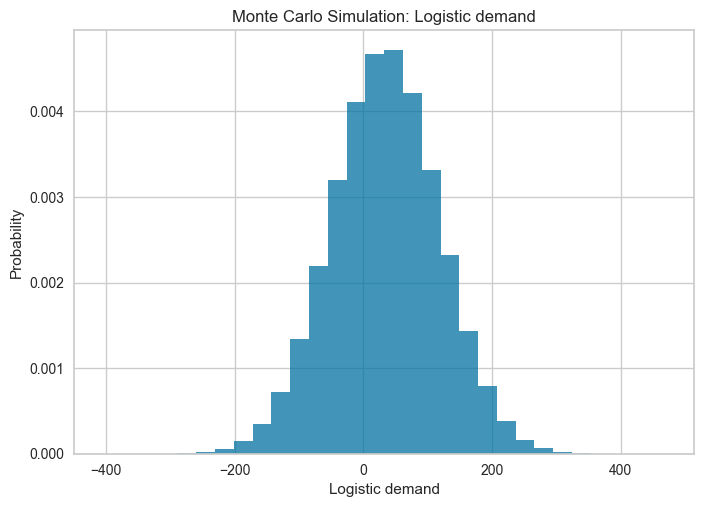

Bin 1: Value = 1.3693612230886678e-08, Bin Edges = (-405.7454951903074, -376.5347951021467)
Bin 2: Value = 4.45042397503817e-08, Bin Edges = (-376.5347951021467, -347.324095013986)
Bin 3: Value = 2.875658568486202e-07, Bin Edges = (-347.324095013986, -318.1133949258253)
Bin 4: Value = 1.3693612230886676e-06, Bin Edges = (-318.1133949258253, -288.90269483766457)
Bin 5: Value = 5.23095987219872e-06, Bin Edges = (-288.90269483766457, -259.6919947495039)
Bin 6: Value = 1.7996829874442797e-05, Bin Edges = (-259.6919947495039, -230.48129466134318)
Bin 7: Value = 5.4445802230005426e-05, Bin Edges = (-230.48129466134318, -201.27059457318248)
Bin 8: Value = 0.0001458301234528277, Bin Edges = (-201.27059457318248, -172.05989448502177)
Bin 9: Value = 0.0003450584877999983, Bin Edges = (-172.05989448502177, -142.8491943968611)
Bin 10: Value = 0.000723029572596932, Bin Edges = (-142.8491943968611, -113.63849430870039)
Bin 11: Value = 0.0013380952829624957, Bin Edges = (-113.63849430870039, -84.4277

In [57]:
# Create histogram
hist_values, bin_edges, _ = plt.hist(samples, bins=30, density=True, alpha=0.75)
plt.xlabel('Logistic demand')
plt.ylabel('Probability')
plt.title('Monte Carlo Simulation: Logistic demand')
plt.show()

# Print values for each bar
for i in range(len(hist_values)):
    print(f'Bin {i+1}: Value = {hist_values[i]}, Bin Edges = ({bin_edges[i]}, {bin_edges[i+1]})')

In [ ]:
# Set thresholds for scenario selection
threshold_bad = np.percentile(samples, 2.5)
threshold_good = np.percentile(samples, 97.5)

# Categorize the simulated outcomes
good_scenarios = samples[samples >= threshold_good]
middle_scenarios = samples[(samples < threshold_good) & (samples > threshold_bad)]
bad_scenarios = samples[samples <= threshold_bad]

# Calculate the probabilities of each scenario
prob_good = len(good_scenarios) / num_samples
prob_middle = len(middle_scenarios) / num_samples
prob_bad = len(bad_scenarios) / num_samples

# Randomly choose a value from the good scenarios
good_value = np.random.choice(good_scenarios)

# Randomly choose a value from the middle scenarios
middle_value = np.random.choice(middle_scenarios)

# Randomly choose a value from the bad scenarios
bad_value = np.random.choice(bad_scenarios)

print(f"Good scenario: {good_value}")
print(f"Middle scenario: {middle_value}")
print(f"Bad scenario: {bad_value}")
print(f"Probability of a good scenario: {prob_good}")
print(f"Probability of a middle scenario: {prob_middle}")
print(f"Probability of a bad scenario: {prob_bad}")

Good scenario: 265.58043669036647
Middle scenario: 127.81779907707494
Bad scenario: -178.9709625656634
Probability of a good scenario: 0.025
Probability of a middle scenario: 0.95
Probability of a bad scenario: 0.025
